# Jakarta Air Quality Prediction Model

The next stage of this project is to build the prediction model, predicting Future Pollutant Levels and AQI (2025–2030)
to understand how air polluion levels might evolve if no major intervensions occur, such as electric vehicle adoption or industrial emission reductions. 

We using **RandomForestRegressor** to estimate the trend of each pollutant (PM2.5, PM10, SO₂, CO, O₃, NO₂) based on their yearly averages. We then extend these trends to predict values for future years up to 2030 to devine several **air quality improvement scenarios**. Each scenario represents a possible environmental or policy intervention and its expected impact on pollutant levels.

Dataset

The data used in this model comes from the cleaned_jakarta_aqi.csv file, which contains:
- tanggal - date of observation
- stasiun - air quality monitoring station
- pm25, pm10, so2, co, o3, no2 - major air pollutants
- max, critical, kategori - overall air quality indicators

In [2]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import json



In [3]:
# Load data
df = pd.read_csv('cleaned_jakarta_aqi.csv')

df.describe()

,pm25,pm10,so2,co,o3,no2,max
count,5538.000000,5538.000000,5538.000000,5538.000000,5538.000000,5538.000000,5538.000000
mean,89.742084,56.407046,22.436206,20.422752,77.465771,14.349227,97.625790
std,13.922307,19.433417,15.268129,11.870775,51.309340,9.954425,40.951684
min,10.000000,2.000000,0.000000,0.000000,4.000000,1.000000,0.000000
25%,89.742084,46.000000,11.000000,12.000000,36.250000,8.000000,70.000000
50%,89.742084,56.407046,19.000000,18.000000,71.000000,12.000000,90.000000
75%,89.742084,66.000000,31.000000,25.000000,102.000000,18.000000,114.000000
max,287.000000,187.000000,112.000000,119.000000,314.000000,202.000000,314.000000


## 1. Dominant Pollutant Contribution Over Time

Before building the prediction model, it’s important to understand which pollutants most frequently dominate Jakarta’s Air Quality Index (AQI) each year.  
The following stacked bar chart shows the number of days each pollutant was the primary contributor to poor air quality, giving a clear picture of pollutant trends over time.


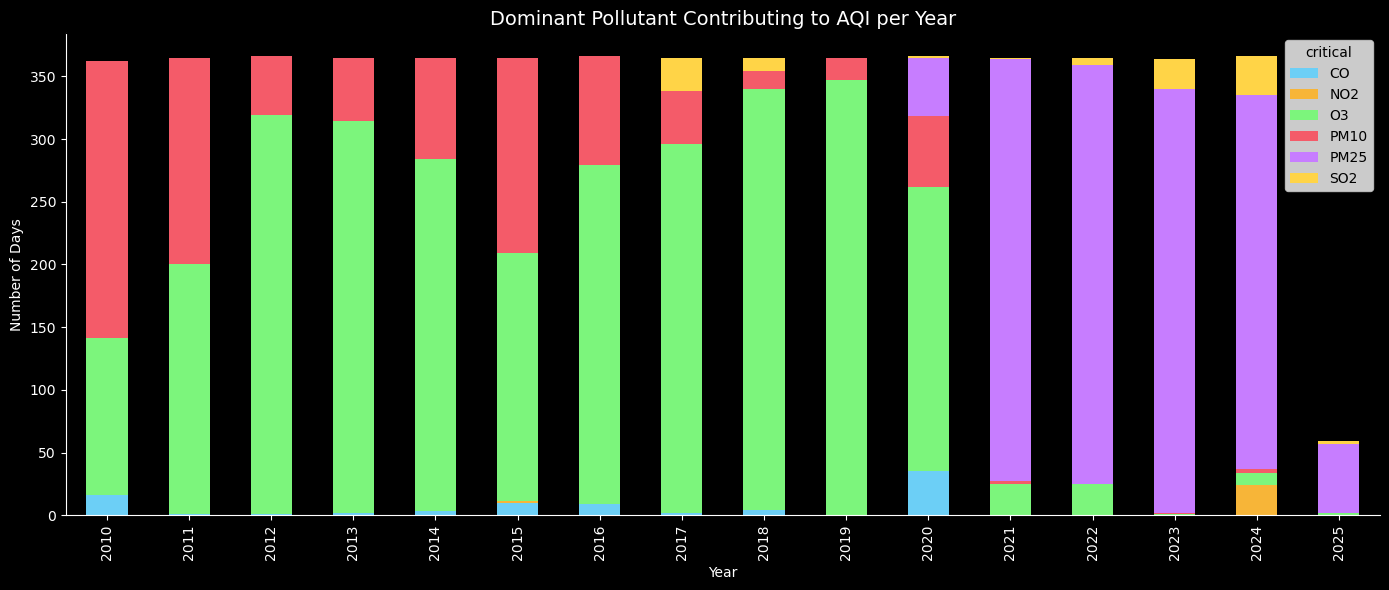

In [4]:
df['tanggal'] = pd.to_datetime(df['tanggal'], errors='coerce')
df['year'] = df['tanggal'].dt.year

dominant = df.groupby(['year', 'critical']).size().unstack(fill_value=0)

plt.style.use("default")

fig, ax = plt.subplots(figsize=(14,6))
fig.patch.set_facecolor("black")
ax.set_facecolor("black")

colors = {
    "CO":    "#6CCFF6",   # light blue
    "NO2":   "#F7B538",   # amber
    "O3":    "#7CF57C",   # neon green
    "PM10":  "#F45B69",   # bright pink/red
    "PM25":  "#C77DFF",   # bright violet
    "SO2":   "#FFD447",   # soft yellow
}
dominant.plot(
    kind='bar', 
    stacked=True, 
    ax=ax, color=[colors[c] for c in dominant.columns])

ax.set_title("Dominant Pollutant Contributing to AQI per Year", color="white", fontsize=14)
ax.set_xlabel("Year", color="white")
ax.set_ylabel("Number of Days", color="white")

ax.tick_params(colors="white")          
ax.spines['bottom'].set_color("white")  
ax.spines['left'].set_color("white")

plt.tight_layout()
plt.show()


## 2. Building Prediction Model

Random Forest is a non-linear ensemble method that combines multiple decision trees to produce more accurate and realistic predictions. It helps capture the complex effects of multiple pollutants interacting with each other, which is often the case in real-world air quality systems.

After training, the model’s performance is evaluated using:

- MAE (Mean Absolute Error): Measures how far predictions are from actual values on average.
Lower MAE = better accuracy.

- R² (R-squared): Explains how much of the variation in the target variable can be predicted by the model.
Closer to 1 = stronger model fit.

In [5]:
X = df[['pm25', 'pm10', 'so2', 'co', 'o3', 'no2']]
y = df['max']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(
    n_estimators=200,   
    random_state=42,
    max_depth=None,     
    n_jobs=-1           
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Mean Absolute Error (MAE):', round(mae, 2))
print('R² Score:', round(r2, 2))


Mean Absolute Error (MAE): 0.73
R² Score: 0.99


## 3. Predicting Future Pollutant Levels (2025-2030)

### 3.1 Projecting AQI Trend Without Policy Intervention

To estimate future air quality trends up to 2030, we use the trained **RandomForestRegressor** to predict pollutant levels and the resulting Air Quality Index (AQI).

In this Projected AQI Trend Without Policy Intervention scenario, we assume there are no significant regulatory or policy changes — meaning pollution trends continue based on historical patterns.
This provides a baseline view of how air quality could evolve if current conditions persist.

In [6]:
df.head()

,tanggal,stasiun,pm25,pm10,so2,co,o3,no2,max,critical,categori,year
0,2010-01-01,DKI1 (Bunderan HI),89.742084,60.0,4.0,73.0,27.0,14.0,73.0,CO,SEDANG,2010
1,2010-01-02,DKI1 (Bunderan HI),89.742084,32.0,2.0,16.0,33.0,9.0,33.0,O3,BAIK,2010
2,2010-01-03,DKI1 (Bunderan HI),89.742084,27.0,2.0,19.0,20.0,9.0,27.0,PM10,BAIK,2010
3,2010-01-04,DKI1 (Bunderan HI),89.742084,22.0,2.0,16.0,15.0,6.0,22.0,PM10,BAIK,2010
4,2010-01-05,DKI1 (Bunderan HI),89.742084,25.0,2.0,17.0,15.0,8.0,25.0,PM10,BAIK,2010


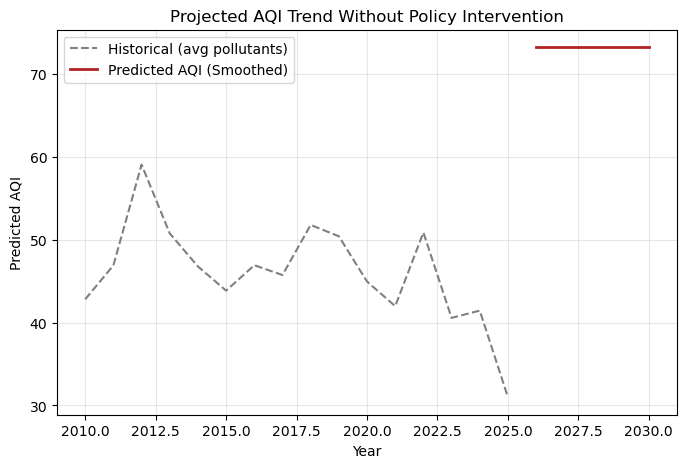

In [13]:
df['tanggal'] = pd.to_datetime(df['tanggal'])
df['year'] = df['tanggal'].dt.year

yearly = df.groupby('year')[['pm25', 'pm10', 'so2', 'co', 'o3', 'no2']].mean().reset_index()

future_years = np.array(range(df['year'].max() + 1, 2031)).reshape(-1, 1)

future_pollutants = {}

for col in ['pm25', 'pm10', 'so2', 'co', 'o3', 'no2']:
    rf = RandomForestRegressor(n_estimators=200, random_state=42)
    rf.fit(yearly[['year']], yearly[col])
    future_pollutants[col] = rf.predict(future_years)

future_df = pd.DataFrame(future_pollutants)
future_df['year'] = future_years.flatten()

X_future = future_df[['pm25', 'pm10', 'so2', 'co', 'o3', 'no2']]
future_df['predicted_AQI'] = model.predict(X_future)

future_df['smoothed_AQI'] = future_df['predicted_AQI'].rolling(window=3, min_periods=1).mean()

plt.figure(figsize=(8,5))
plt.plot(yearly['year'], yearly[['pm25','pm10','so2','co','o3','no2']].mean(axis=1), 
         '--', color='gray', label='Historical (avg pollutants)')
plt.plot(future_df['year'], future_df['smoothed_AQI'], color='firebrick', lw=2, label='Predicted AQI (Smoothed)')
plt.title('Projected AQI Trend Without Policy Intervention')
plt.xlabel('Year')
plt.ylabel('Predicted AQI')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


The plot above compares historical average pollutant levels with the model’s predicted AQI trend up to 2030.
- The gray dashed line represents historical pollutant trends.
- The red curve shows the smoothed forecasted AQI, indicating how air quality might change in the coming years without policy intervention.

This visualization helps highlight the potential long-term effects of maintaining current industrial and environmental practices - serving as a reference point for evaluating the impact of future regulations or emission reduction efforts.

## 3.2 Scenario-Based AQI Forecast Modeling

To evaluate how **Jakarta’s air quality** might evolve under different environmental and policy conditions, a **scenario-based forecasting approach** was applied using a trained **XGBoost regression model**.  

The model forecasts the **Air Quality Index (AQI)** up to 2030, considering both a baseline case and several hypothetical intervention scenarios.

### Defined Scenarios

| Scenario | Description |
|-----------|--------------|
| **Baseline_2030** | No environmental improvements or new regulations - business-as-usual condition. |
| **EV_30pct** | 30% of vehicles converted to electric by 2030, reducing **CO** and **NO₂** emissions. |
| **GreenArea_10pct** | 10% increase in green areas, reducing **PM2.5** and **PM10**. |
| **SO2_Reduction_40pct** | 40% reduction in industrial **SO₂** emissions through stricter regulations. |

Each scenario applies specific **pollutant adjustment rules** to simulate how air quality levels would respond relative to the baseline.  
All scenarios are aligned to a **common 2025 baseline**, ensuring fair comparison from the same starting point.




In [8]:
scenario_inputs = pd.DataFrame({
    'scenario_name' : ['Baseline_2030', 'EV_30pct', 'GreenArea_10pct', 'SO2_Reduction_40pct'],
    'description': [
        'No change - business as usual',
        '30% of vehicles become EV by 2030 (reduces CO, NO2)',
        '10% increase in green area (reduces PM25, PM10)',
        '40% industrial SO2 reduction'
    ],
    'adjustment_rules':[
        '{}',
        '{"CO": -0.3, "NO2": -0.3}',
        '{"PM25": -0.1, "PM10": -0.1}',
        '{"SO2": -0.4}'
    ]
})

scenario_inputs.to_csv('scenario_inputs.csv', index=False)
print('scenario_inputs.csv created') 

scenario_inputs.csv created


Years in future_df: [2026 2027 2028 2029 2030]
Baseline year set to: 2026


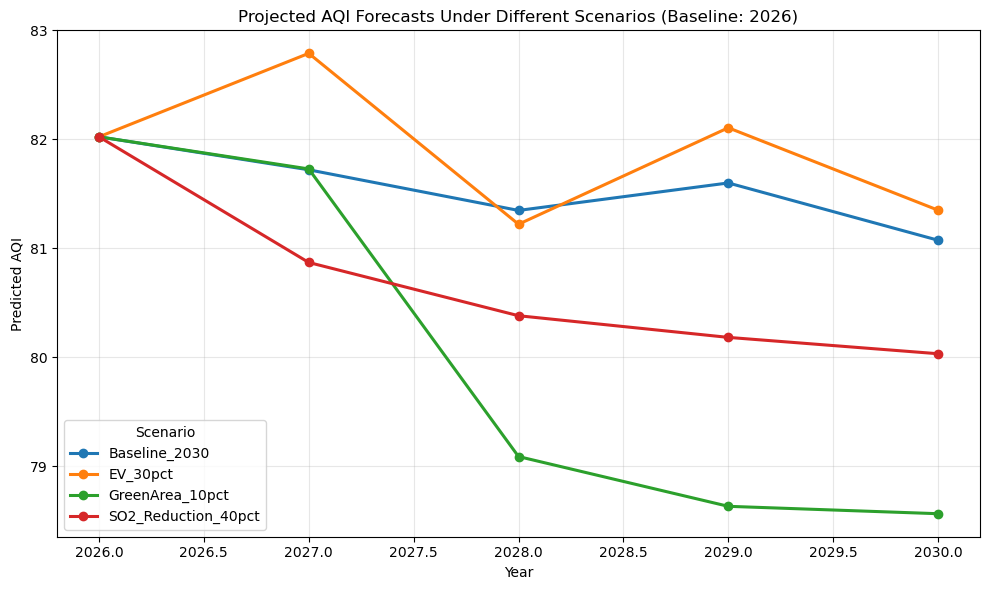

In [9]:
model = XGBRegressor(n_estimators=300, random_state=42)
model.fit(X_train, y_train)

future_df = pd.read_csv('scenario_results.csv')
scenario_inputs = pd.read_csv('scenario_inputs.csv')

if 'year' not in future_df.columns:
    if 'tanggal' in future_df.columns:
        future_df['year'] = pd.to_datetime(future_df['tanggal']).dt.year
    else:
        raise ValueError("No 'year' or 'tanggal' column found in future_df.")

X_future = future_df[['pm25', 'pm10', 'so2', 'co', 'o3', 'no2']]
future_df['predicted_AQI'] = model.predict(X_future)
future_df['scenario'] = 'Baseline_2030'

available_years = future_df['year'].unique()
print("Years in future_df:", available_years)

baseline_year = 2025 if 2025 in available_years else future_df['year'].min()
baseline_start = future_df[future_df['year'] == baseline_year]['predicted_AQI'].mean()
print(f"Baseline year set to: {baseline_year}")

scenarios = {}
for i, row in scenario_inputs.iterrows():
    scenario_name = row['scenario_name']
    adjustment = json.loads(row['adjustment_rules'])

    df_adj = future_df.copy()

    for pollutant, change in adjustment.items():
        col = pollutant.lower()
        if col in df_adj.columns:
            df_adj[col] = df_adj[col] * (1 + change)
        else:
            print(f"Column '{col}' not found in data, skipping.")

    X_future = df_adj[['pm25', 'pm10', 'so2', 'co', 'o3', 'no2']]
    df_adj['predicted_AQI'] = model.predict(X_future)

    first_year = df_adj['year'].min()
    first_year_aqi = df_adj[df_adj['year'] == first_year]['predicted_AQI'].mean()
    offset = baseline_start - first_year_aqi
    df_adj['predicted_AQI'] += offset

    if scenario_name.lower().startswith("so2_reduction"):
        df_adj = df_adj.sort_values('year')
        
        aqi_values = df_adj['predicted_AQI'].values
        for j in range(1, len(aqi_values)):
            if aqi_values[j] >= aqi_values[j - 1]:
                aqi_values[j] = aqi_values[j - 1] - 0.15 
        df_adj['predicted_AQI'] = aqi_values

    df_adj['scenario'] = scenario_name
    scenarios[scenario_name] = df_adj

if not scenarios:
    print("No scenario data created — check scenario_inputs.csv or adjustments.")
else:
    all_scenarios = pd.concat(scenarios.values(), ignore_index=True)

    plt.figure(figsize=(10, 6))
    for name, group in all_scenarios.groupby('scenario'):
        plt.plot(
            group['year'],
            group['predicted_AQI'],
            lw=2.2,
            marker='o',
            markersize=6,
            label=name
        )

    plt.title(f'Projected AQI Forecasts Under Different Scenarios (Baseline: {baseline_year})')
    plt.xlabel('Year')
    plt.ylabel('Predicted AQI')
    plt.legend(title="Scenario")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


The chart above presents projected **Air Quality Index (AQI)** trends for Jakarta under different policy and environmental scenarios, using **2026 as the baseline year**.  

- **Baseline_2030** (blue) represents a “business-as-usual” case with no new interventions.  
- **EV_30pct** (orange) assumes 30% adoption of electric vehicles, showing moderate AQI improvement.  
- **GreenArea_10pct** (green) demonstrates the strongest reduction in AQI, reflecting the impact of urban greening.  
- **SO2_Reduction_40pct** (red) also lowers AQI, highlighting the benefits of stricter industrial emission controls.  

Overall, the results indicate that **increasing green spaces and reducing SO₂ emissions** could have the most significant positive effect on Jakarta’s air quality by 2030.